# EXIST2026 - Sensorial Signal Significance Analysis

This notebook analyzes whether **Eye Tracking (ET)**, **EEG**, and **Heart Rate (HR)** signals are statistically significant predictors of sexism perception (label `labels_task2_1`).

## Methodology
- **Label**: `labels_task2_1` — majority vote (YES = sexist, NO = not sexist)
- **Statistical tests**: Mann-Whitney U (non-parametric, no normality assumption) + FDR correction (Benjamini-Hochberg)
- **Effect size**: Cohen's d / rank-biserial correlation
- One row per (meme_id × user) observation, aggregating signals per modality

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro, levene
from statsmodels.stats.multitest import multipletests
from collections import Counter
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

## 1. Load Data

In [3]:
JSON_PATH = Path('../materials/dataset_task2_exist2026/training.json')

with open(JSON_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f'Total memes loaded: {len(raw_data)}')
print(f'Example keys: {list(list(raw_data.values())[0].keys())}')

Total memes loaded: 2683
Example keys: ['id_EXIST', 'lang', 'text', 'meme', 'path_memes', 'number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'ethnicities_annotators', 'study_levels_annotators', 'countries_annotators', 'sensorial', 'labels_task2_1', 'labels_task2_2', 'labels_task2_3', 'split']


## 2. Label Extraction — Majority Vote

In [4]:
def majority_vote(label_list):
    """Returns the most common label. Ties broken alphabetically."""
    counts = Counter(label_list)
    return counts.most_common(1)[0][0]

label_map = {}
for meme_id, entry in raw_data.items():
    labels = entry.get('labels_task2_1', [])
    if labels:
        label_map[meme_id] = majority_vote(labels)

label_counts = Counter(label_map.values())
print('Label distribution (majority vote):')
for label, count in sorted(label_counts.items()):
    print(f'  {label}: {count} ({count/len(label_map)*100:.1f}%)')

Label distribution (majority vote):
  NO: 1080 (40.3%)
  YES: 1603 (59.7%)


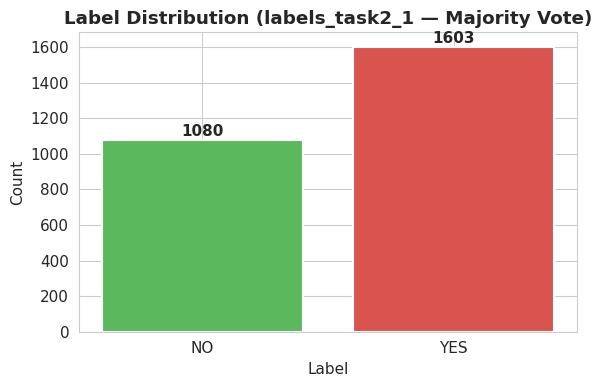

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]
colors = ['#d9534f' if l == 'YES' else '#5cb85c' for l in labels_sorted]
bars = ax.bar(labels_sorted, counts_sorted, color=colors, edgecolor='white', linewidth=1.5)
for bar, count in zip(bars, counts_sorted):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')
ax.set_title('Label Distribution (labels_task2_1 — Majority Vote)', fontweight='bold')
ax.set_ylabel('Count')
ax.set_xlabel('Label')
plt.tight_layout()
plt.show()

## 3. Feature Extraction per Modality

Each observation = one user viewing one meme. The label is the meme's majority vote.

In [6]:
et_rows, hr_rows, eeg_rows = [], [], []

for meme_id, entry in raw_data.items():
    label = label_map.get(meme_id)
    if label is None:
        continue

    sensorial = entry.get('sensorial', {})
    modalities = sensorial.get('modalities', {})

    # ── Eye Tracking ────────────────────────────────────────────────────────
    et_users = modalities.get('ET', {}).get('by_user', {})
    for user, feats in et_users.items():
        row = {'meme_id': meme_id, 'user': user, 'label': label}
        row.update(feats)
        et_rows.append(row)

    # ── Heart Rate ───────────────────────────────────────────────────────────
    hr_users = modalities.get('HR', {}).get('by_user', {})
    for user, feats in hr_users.items():
        row = {'meme_id': meme_id, 'user': user, 'label': label}
        row.update(feats)
        hr_rows.append(row)

    # ── EEG ─────────────────────────────────────────────────────────────────
    eeg_users = modalities.get('EEG', {}).get('by_user', {})
    for user, feats in eeg_users.items():
        row = {'meme_id': meme_id, 'user': user, 'label': label}
        row.update(feats)
        eeg_rows.append(row)

df_et  = pd.DataFrame(et_rows)
df_hr  = pd.DataFrame(hr_rows)
df_eeg = pd.DataFrame(eeg_rows)

print(f'ET  observations: {len(df_et)}  | features: {df_et.shape[1]-3}')
print(f'HR  observations: {len(df_hr)}  | features: {df_hr.shape[1]-3}')
print(f'EEG observations: {len(df_eeg)} | features: {df_eeg.shape[1]-3}')

ET  observations: 5540  | features: 24
HR  observations: 5537  | features: 4
EEG observations: 5436 | features: 80


In [7]:
# Quick class balance per modality
for name, df in [('ET', df_et), ('HR', df_hr), ('EEG', df_eeg)]:
    print(f'{name}: {dict(df["label"].value_counts())}')

ET: {'YES': np.int64(3304), 'NO': np.int64(2236)}
HR: {'YES': np.int64(3307), 'NO': np.int64(2230)}
EEG: {'YES': np.int64(3254), 'NO': np.int64(2182)}


## 4. Statistical Significance Testing

For each feature:
1. **Shapiro-Wilk** test to check normality per group
2. **Mann-Whitney U** test (non-parametric, robust) — `YES` vs `NO`
3. **FDR correction** via Benjamini-Hochberg to control false discovery rate
4. **Rank-biserial correlation** as effect size (|r| > 0.1 small, > 0.3 medium, > 0.5 large)

In [8]:
def rank_biserial(group1, group2):
    """Effect size for Mann-Whitney U: rank-biserial correlation."""
    n1, n2 = len(group1), len(group2)
    if n1 == 0 or n2 == 0:
        return np.nan
    U, _ = mannwhitneyu(group1, group2, alternative='two-sided')
    r = 1 - (2 * U) / (n1 * n2)
    return r


def test_modality(df, modality_name, alpha=0.05):
    """Run Mann-Whitney U + BH correction on all numeric features."""
    feature_cols = [c for c in df.columns if c not in ('meme_id', 'user', 'label')]
    df_clean = df.dropna(subset=feature_cols)

    groups = df_clean['label'].unique()
    if len(groups) < 2:
        print(f'[{modality_name}] Only one class present — skipping.')
        return pd.DataFrame()

    group_yes = df_clean[df_clean['label'] == 'YES']
    group_no  = df_clean[df_clean['label'] == 'NO']

    results = []
    for feat in feature_cols:
        g1 = group_yes[feat].dropna().values
        g2 = group_no[feat].dropna().values
        if len(g1) < 3 or len(g2) < 3:
            continue
        try:
            stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
            r = rank_biserial(g1, g2)
            effect_label = ('large' if abs(r) > 0.5
                            else 'medium' if abs(r) > 0.3
                            else 'small')
            results.append({
                'feature': feat,
                'mean_YES': g1.mean(),
                'mean_NO':  g2.mean(),
                'n_YES': len(g1),
                'n_NO':  len(g2),
                'U_stat': stat,
                'p_value': p,
                'effect_r': r,
                'effect_label': effect_label
            })
        except Exception as e:
            pass

    if not results:
        return pd.DataFrame()

    res_df = pd.DataFrame(results)

    # FDR correction (Benjamini-Hochberg)
    reject, p_adj, _, _ = multipletests(res_df['p_value'], alpha=alpha, method='fdr_bh')
    res_df['p_adj_BH'] = p_adj
    res_df['significant'] = reject
    res_df['modality'] = modality_name

    return res_df.sort_values('p_adj_BH')


res_et  = test_modality(df_et,  'ET')
res_hr  = test_modality(df_hr,  'HR')
res_eeg = test_modality(df_eeg, 'EEG')

print(f'ET  — {len(res_et)} features tested,  {res_et["significant"].sum() if len(res_et) else 0} significant (FDR 5%)')
print(f'HR  — {len(res_hr)} features tested,  {res_hr["significant"].sum() if len(res_hr) else 0} significant (FDR 5%)')
print(f'EEG — {len(res_eeg)} features tested, {res_eeg["significant"].sum() if len(res_eeg) else 0} significant (FDR 5%)')

ET  — 24 features tested,  9 significant (FDR 5%)
HR  — 4 features tested,  1 significant (FDR 5%)
EEG — 80 features tested, 0 significant (FDR 5%)


## 5. Results Tables

In [9]:
def display_results(res_df, modality_name, top_n=20):
    if res_df.empty:
        print(f'No results for {modality_name}')
        return
    cols = ['feature', 'mean_YES', 'mean_NO', 'p_value', 'p_adj_BH', 'effect_r', 'effect_label', 'significant']
    display_df = res_df[cols].head(top_n).copy()
    display_df['mean_YES'] = display_df['mean_YES'].round(4)
    display_df['mean_NO']  = display_df['mean_NO'].round(4)
    display_df['p_value']  = display_df['p_value'].apply(lambda x: f'{x:.4f}')
    display_df['p_adj_BH'] = display_df['p_adj_BH'].apply(lambda x: f'{x:.4f}')
    display_df['effect_r'] = display_df['effect_r'].round(3)
    print(f'\n─── {modality_name} — Top {top_n} features (sorted by adjusted p-value) ───')
    print(display_df.to_string(index=False))

display_results(res_et,  'Eye Tracking (ET)')
display_results(res_hr,  'Heart Rate (HR)')
display_results(res_eeg, 'EEG', top_n=30)


─── Eye Tracking (ET) — Top 20 features (sorted by adjusted p-value) ───
                                    feature     mean_YES      mean_NO p_value p_adj_BH  effect_r effect_label  significant
                              reaction_time 1.745609e+04 1.586399e+04  0.0000   0.0000    -0.145        small         True
                            fixations_count 4.972730e+01 4.697280e+01  0.0000   0.0002    -0.089        small         True
                             saccades_count 4.921610e+01 4.646080e+01  0.0000   0.0002    -0.090        small         True
                 fixations_duration_mean_ns 2.841075e+08 2.728742e+08  0.0002   0.0011    -0.080        small         True
                     blinks_duration_min_ns 2.413790e+08 2.493557e+08  0.0004   0.0020     0.075        small         True
                  fixations_duration_std_ns 2.374723e+08 2.220157e+08  0.0010   0.0038    -0.070        small         True
                    blinks_duration_mean_ns 2.585673e+08 2.651165

## 6. Volcano Plots — Effect Size vs. Significance

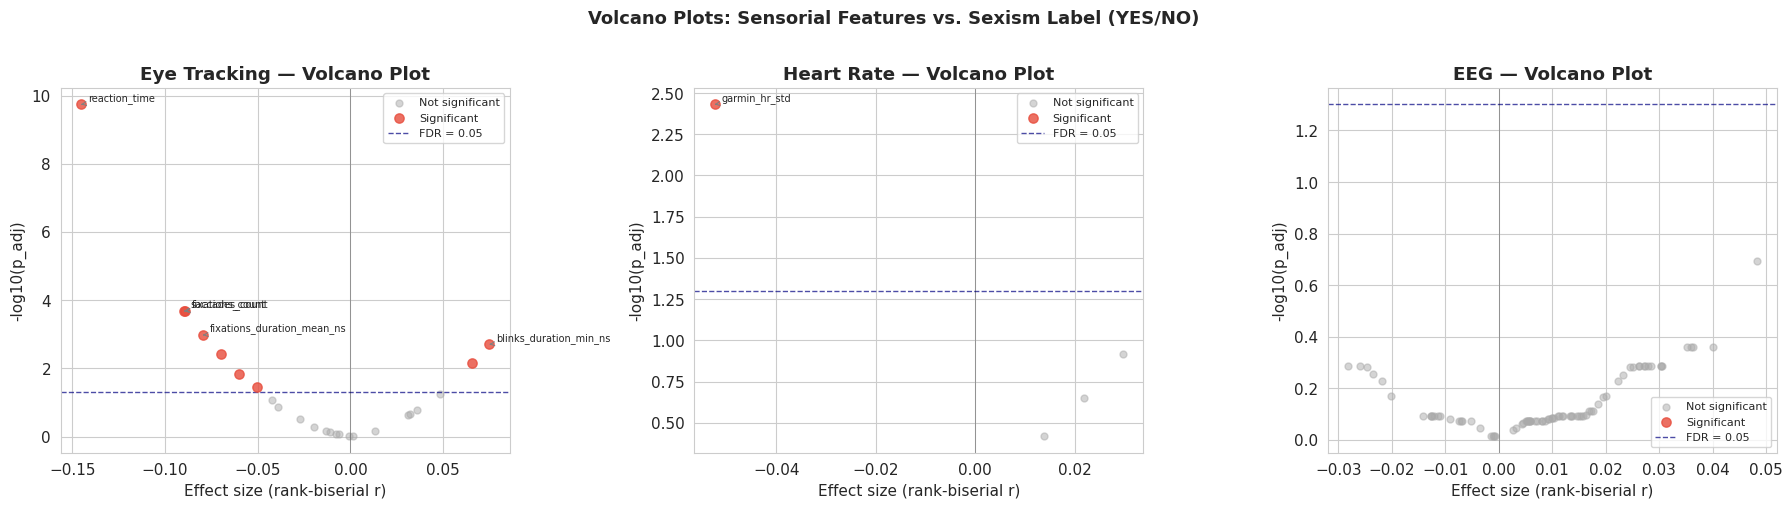

In [10]:
def volcano_plot(res_df, modality_name, ax, alpha=0.05):
    if res_df.empty:
        ax.text(0.5, 0.5, f'No data\n({modality_name})', ha='center', va='center',
                transform=ax.transAxes, fontsize=12)
        ax.set_title(modality_name)
        return

    x = res_df['effect_r']
    y = -np.log10(res_df['p_adj_BH'].clip(lower=1e-10))
    sig = res_df['significant']

    ax.scatter(x[~sig], y[~sig], alpha=0.5, c='#aaaaaa', s=25, label='Not significant')
    ax.scatter(x[sig],  y[sig],  alpha=0.8, c='#e74c3c', s=45, zorder=3, label='Significant')

    # Threshold line
    ax.axhline(-np.log10(alpha), color='navy', linestyle='--', linewidth=1, alpha=0.7,
               label=f'FDR = {alpha}')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.4)

    # Label top significant
    top = res_df[sig].nsmallest(5, 'p_adj_BH')
    for _, row in top.iterrows():
        rx = row['effect_r']
        ry = -np.log10(max(row['p_adj_BH'], 1e-10))
        label_text = row['feature'].replace('3d_eye_states_', '').replace('_power', '')
        ax.annotate(label_text, (rx, ry), fontsize=7,
                    xytext=(5, 3), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))

    ax.set_xlabel('Effect size (rank-biserial r)')
    ax.set_ylabel('-log10(p_adj)')
    ax.set_title(f'{modality_name} — Volcano Plot', fontweight='bold')
    ax.legend(fontsize=8)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
volcano_plot(res_et,  'Eye Tracking', axes[0])
volcano_plot(res_hr,  'Heart Rate',   axes[1])
volcano_plot(res_eeg, 'EEG',          axes[2])
plt.suptitle('Volcano Plots: Sensorial Features vs. Sexism Label (YES/NO)',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('volcano_plots.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Box Plots — Significant Features

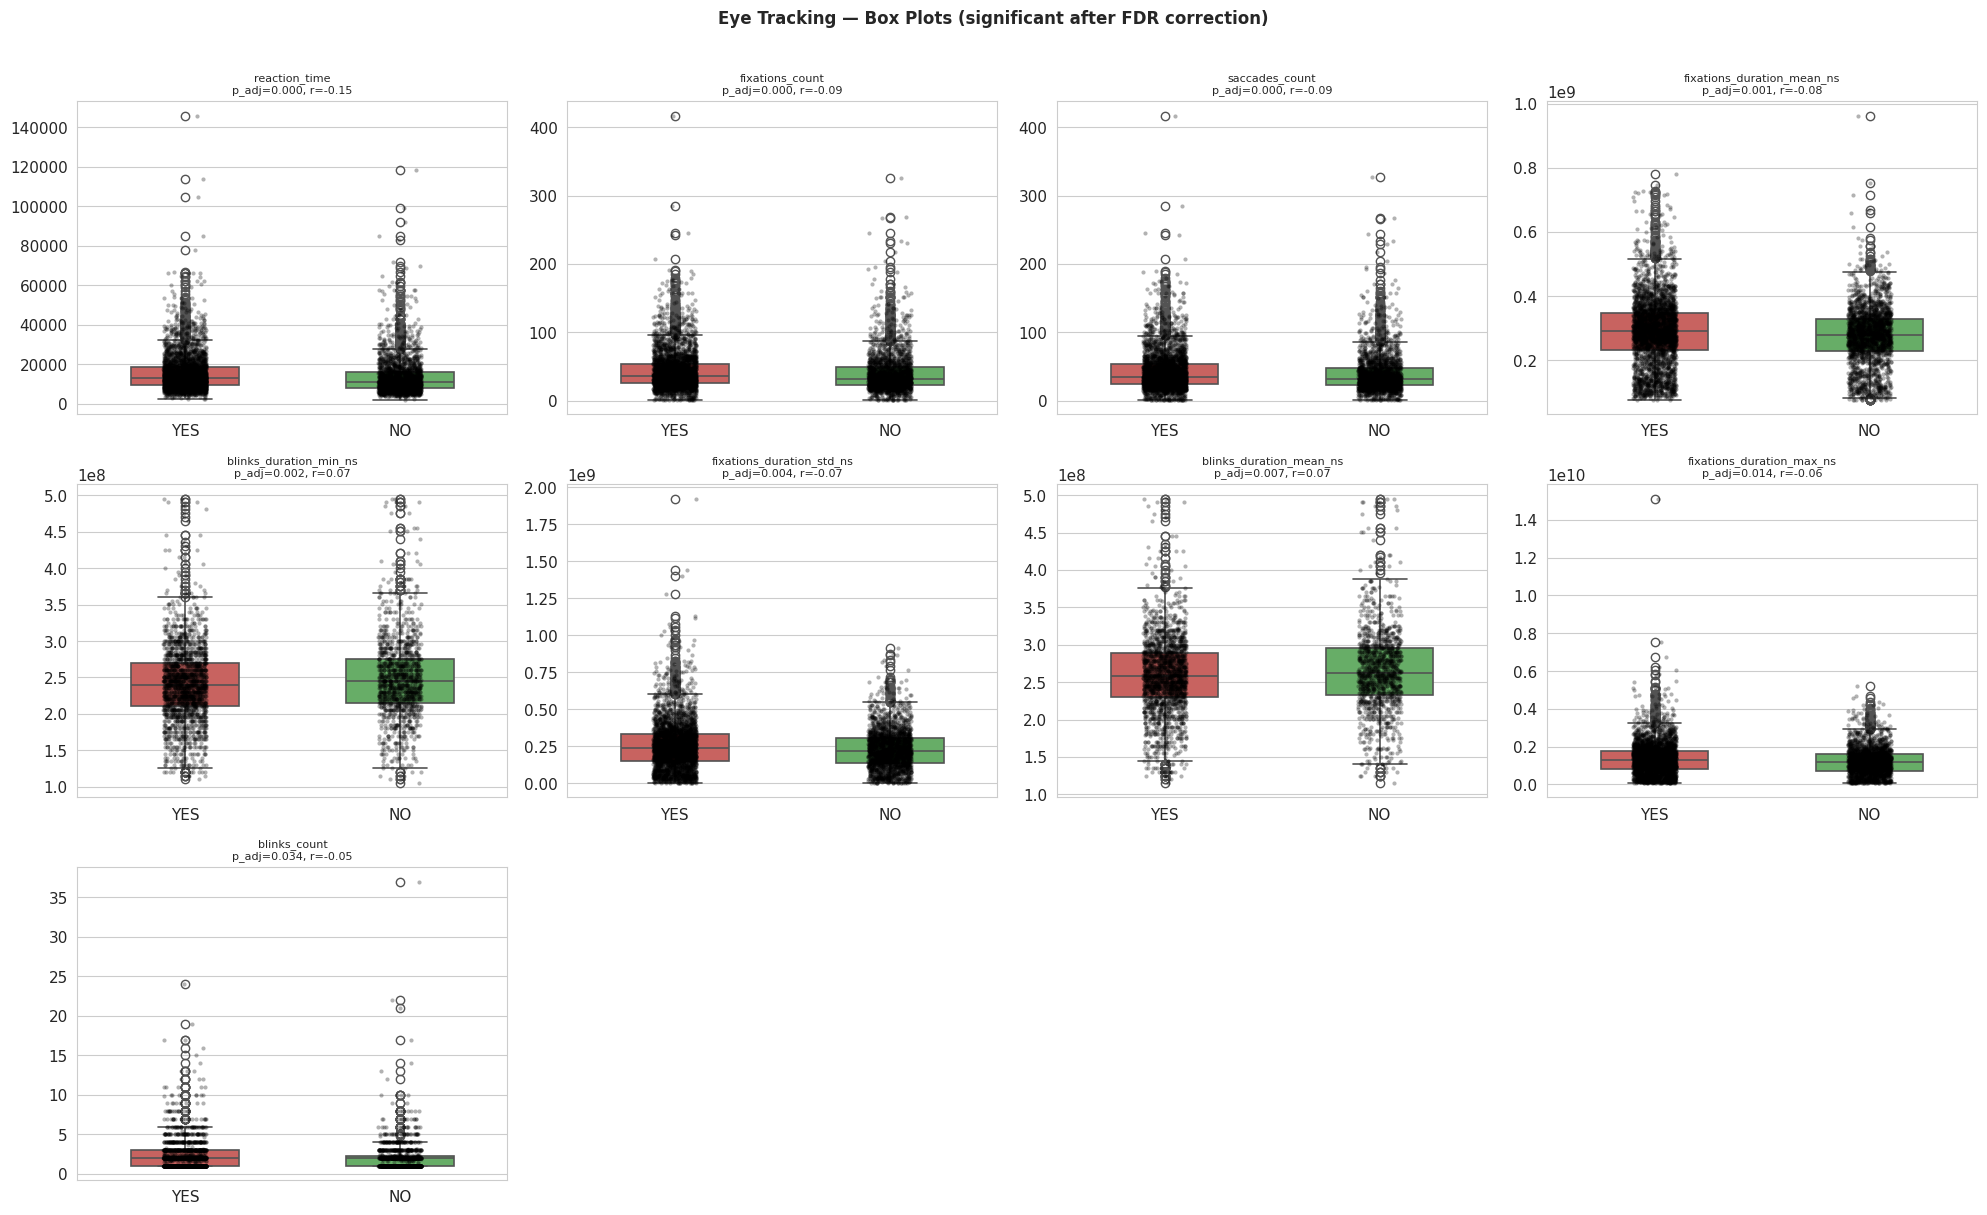

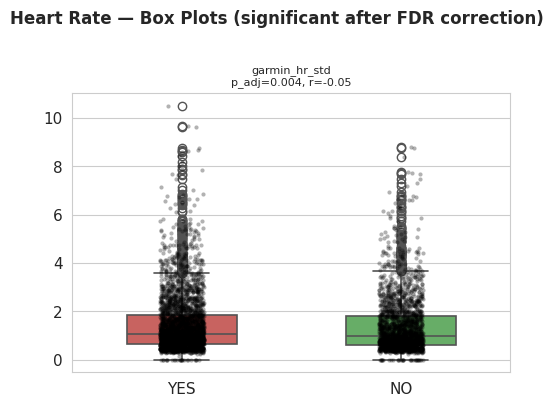

[EEG] No significant features to plot.


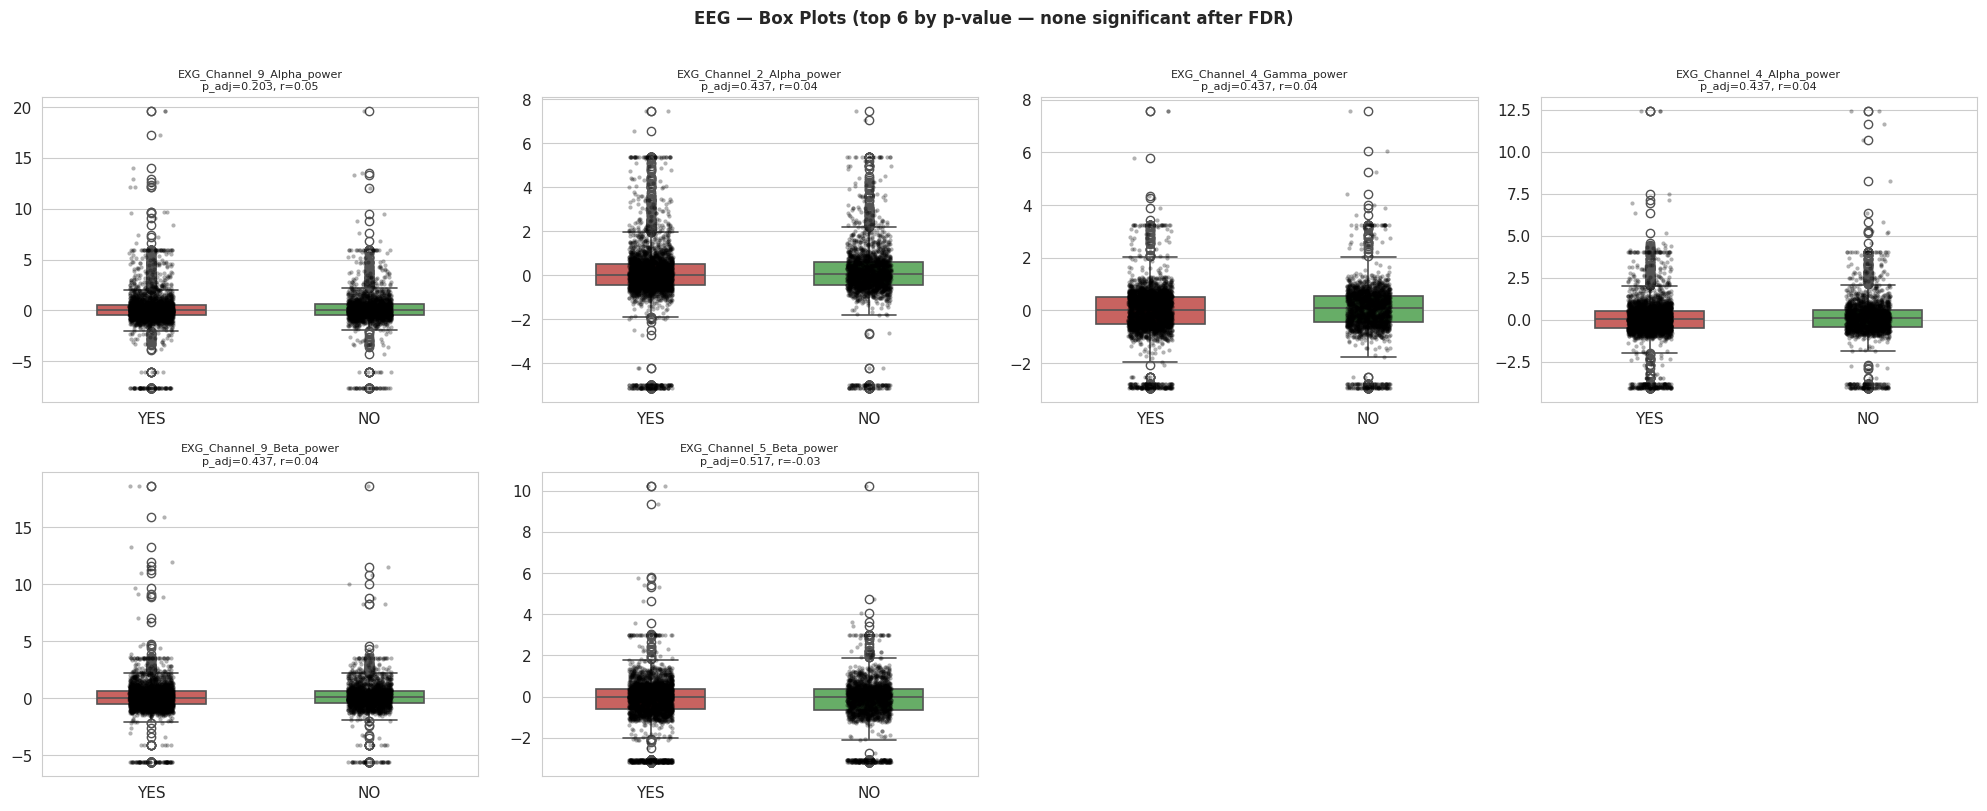

In [11]:
def plot_significant_boxplots(df, res_df, modality_name, max_feats=12):
    if res_df.empty:
        return
    sig_feats = res_df[res_df['significant']]['feature'].tolist()
    if not sig_feats:
        print(f'[{modality_name}] No significant features to plot.')
        # Show top 6 by p-value anyway
        sig_feats = res_df.head(6)['feature'].tolist()
        title_suffix = '(top 6 by p-value — none significant after FDR)'
    else:
        sig_feats = sig_feats[:max_feats]
        title_suffix = '(significant after FDR correction)'

    n = len(sig_feats)
    ncols = min(4, n)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    palette = {'YES': '#d9534f', 'NO': '#5cb85c'}

    for i, feat in enumerate(sig_feats):
        ax = axes[i]
        plot_df = df[['label', feat]].dropna()
        sns.boxplot(data=plot_df, x='label', y=feat, palette=palette, ax=ax,
                    order=['YES', 'NO'], width=0.5, linewidth=1.2)
        sns.stripplot(data=plot_df, x='label', y=feat, order=['YES', 'NO'],
                      color='black', alpha=0.3, size=3, ax=ax, jitter=True)

        # Annotate with adjusted p-value
        prow = res_df[res_df['feature'] == feat]
        if not prow.empty:
            p_adj = prow['p_adj_BH'].values[0]
            r_val = prow['effect_r'].values[0]
            ax.set_title(f'{feat}\np_adj={p_adj:.3f}, r={r_val:.2f}', fontsize=8)
        else:
            short = feat.replace('3d_eye_states_', '').replace('_power', '')
            ax.set_title(short, fontsize=8)

        ax.set_xlabel('')
        ax.set_ylabel('')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f'{modality_name} — Box Plots {title_suffix}',
                 fontsize=12, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(f'boxplots_{modality_name.lower().replace(" ", "_")}.png',
                dpi=150, bbox_inches='tight')
    plt.show()


plot_significant_boxplots(df_et,  res_et,  'Eye Tracking')
plot_significant_boxplots(df_hr,  res_hr,  'Heart Rate')
plot_significant_boxplots(df_eeg, res_eeg, 'EEG')

## 8. EEG Band-level Summary

Group EEG results by frequency band (Delta, Theta, Alpha, Beta, Gamma) to see which bands are most discriminative.

EEG Band Summary:
 Band  n_features  n_significant  median_p_adj  median_effect_r  max_effect_r
Delta          16              0      0.834604         0.000701      0.027373
Theta          16              0      0.826516         0.005482      0.025069
Alpha          16              0      0.519600         0.024260      0.048227
 Beta          16              0      0.804532         0.008965      0.036319
Gamma          16              0      0.786636         0.015273      0.036013


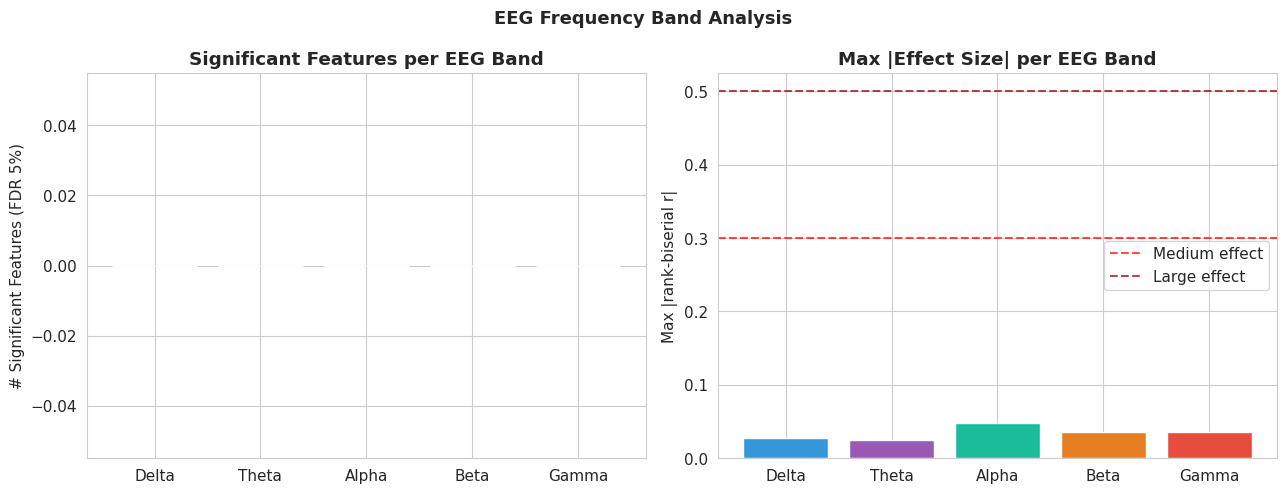

In [12]:
if not res_eeg.empty:
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    band_summary = []
    for band in bands:
        band_feats = res_eeg[res_eeg['feature'].str.contains(band)]
        if band_feats.empty:
            continue
        band_summary.append({
            'Band': band,
            'n_features': len(band_feats),
            'n_significant': band_feats['significant'].sum(),
            'median_p_adj': band_feats['p_adj_BH'].median(),
            'median_effect_r': band_feats['effect_r'].median(),
            'max_effect_r': band_feats['effect_r'].abs().max()
        })

    band_df = pd.DataFrame(band_summary)
    print('EEG Band Summary:')
    print(band_df.to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    colors = ['#3498db', '#9b59b6', '#1abc9c', '#e67e22', '#e74c3c']
    axes[0].bar(band_df['Band'], band_df['n_significant'],
                color=colors[:len(band_df)], edgecolor='white')
    axes[0].set_title('Significant Features per EEG Band', fontweight='bold')
    axes[0].set_ylabel('# Significant Features (FDR 5%)')

    axes[1].bar(band_df['Band'], band_df['max_effect_r'],
                color=colors[:len(band_df)], edgecolor='white')
    axes[1].set_title('Max |Effect Size| per EEG Band', fontweight='bold')
    axes[1].set_ylabel('Max |rank-biserial r|')
    axes[1].axhline(0.3, color='red', linestyle='--', alpha=0.7, label='Medium effect')
    axes[1].axhline(0.5, color='darkred', linestyle='--', alpha=0.7, label='Large effect')
    axes[1].legend()

    plt.suptitle('EEG Frequency Band Analysis', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('eeg_band_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('EEG results not available.')

## 9. Heatmap — EEG Channels × Bands (Effect Size)

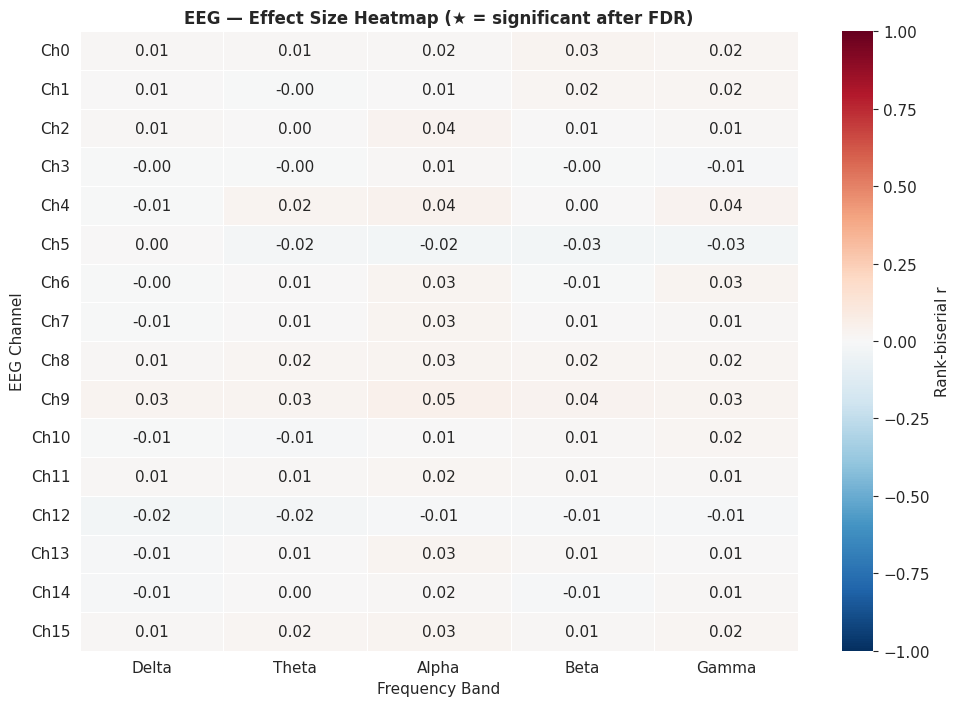

In [13]:
if not res_eeg.empty:
    import re
    bands   = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    pattern = re.compile(r'EXG_Channel_(\d+)_(' + '|'.join(bands) + r')_power')

    channels = sorted(set(
        int(pattern.match(f).group(1))
        for f in res_eeg['feature'] if pattern.match(f)
    ))

    heatmap_data = pd.DataFrame(index=[f'Ch{c}' for c in channels], columns=bands, dtype=float)
    sig_mask     = pd.DataFrame(False, index=[f'Ch{c}' for c in channels], columns=bands)

    for _, row in res_eeg.iterrows():
        m = pattern.match(row['feature'])
        if m:
            ch   = f'Ch{int(m.group(1))}'
            band = m.group(2)
            heatmap_data.loc[ch, band]  = row['effect_r']
            sig_mask.loc[ch, band]      = row['significant']

    heatmap_data = heatmap_data.astype(float)

    fig, ax = plt.subplots(figsize=(10, max(6, len(channels) * 0.45)))
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                annot=True, fmt='.2f', linewidths=0.4, ax=ax,
                cbar_kws={'label': 'Rank-biserial r'})

    # Mark significant cells with a star
    for r_idx, ch in enumerate([f'Ch{c}' for c in channels]):
        for c_idx, band in enumerate(bands):
            if sig_mask.loc[ch, band]:
                ax.text(c_idx + 0.85, r_idx + 0.25, '★', color='gold',
                        fontsize=9, fontweight='bold')

    ax.set_title('EEG — Effect Size Heatmap (★ = significant after FDR)',
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('EEG Channel')
    plt.tight_layout()
    plt.savefig('eeg_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('EEG results not available.')

## 10. Global Summary

In [14]:
all_results = pd.concat([r for r in [res_et, res_hr, res_eeg] if not r.empty], ignore_index=True)

summary = (
    all_results.groupby('modality')
    .agg(
        total_features=('feature', 'count'),
        n_significant=('significant', 'sum'),
        pct_significant=('significant', lambda x: f'{x.mean()*100:.1f}%'),
        best_p_adj=('p_adj_BH', 'min'),
        max_effect=('effect_r', lambda x: x.abs().max())
    )
    .reset_index()
)
summary['best_p_adj'] = summary['best_p_adj'].apply(lambda x: f'{x:.4f}')
summary['max_effect'] = summary['max_effect'].round(3)

print('\n═══ GLOBAL SUMMARY ═══')
print(summary.to_string(index=False))

print('\n─── Top 10 most significant features (across all modalities) ───')
top10 = (
    all_results
    .nsmallest(10, 'p_adj_BH')
    [['modality', 'feature', 'mean_YES', 'mean_NO', 'p_adj_BH', 'effect_r', 'effect_label', 'significant']]
)
top10['mean_YES']  = top10['mean_YES'].round(4)
top10['mean_NO']   = top10['mean_NO'].round(4)
top10['p_adj_BH']  = top10['p_adj_BH'].apply(lambda x: f'{x:.4f}')
top10['effect_r']  = top10['effect_r'].round(3)
print(top10.to_string(index=False))


═══ GLOBAL SUMMARY ═══
modality  total_features  n_significant pct_significant best_p_adj  max_effect
     EEG              80              0            0.0%     0.2032       0.048
      ET              24              9           37.5%     0.0000       0.145
      HR               4              1           25.0%     0.0037       0.052

─── Top 10 most significant features (across all modalities) ───
modality                    feature     mean_YES      mean_NO p_adj_BH  effect_r effect_label  significant
      ET              reaction_time 1.745609e+04 1.586399e+04   0.0000    -0.145        small         True
      ET            fixations_count 4.972730e+01 4.697280e+01   0.0002    -0.089        small         True
      ET             saccades_count 4.921610e+01 4.646080e+01   0.0002    -0.090        small         True
      ET fixations_duration_mean_ns 2.841075e+08 2.728742e+08   0.0011    -0.080        small         True
      ET     blinks_duration_min_ns 2.413790e+08 2.493557e+

In [15]:
# Save all results to CSV
all_results.to_csv('sensorial_significance_results.csv', index=False)
print('Results saved to: sensorial_significance_results.csv')

Results saved to: sensorial_significance_results.csv


## 11. Interpretation Guide

| Metric | Interpretation |
|--------|----------------|
| `p_adj_BH < 0.05` | Significant after FDR correction |
| `effect_r` | Rank-biserial correlation: +1 = YES always higher, -1 = NO always higher |
| `\|r\| > 0.1` | Small effect |
| `\|r\| > 0.3` | Medium effect |
| `\|r\| > 0.5` | Large effect |

**Notes**:
- The Mann-Whitney U test makes **no normality assumption** — appropriate for physiological signals.
- Benjamini-Hochberg FDR controls the expected proportion of false positives among significant results.
- Given the nested structure (multiple users × memes), results should be interpreted cautiously; mixed-effects models would be a logical next step if significance is found.